In [2]:
import torch
import pandas as pd
from transformers import pipeline
torch.cuda.is_available()

c:\Users\Jonathan\Desktop\Text Analytics\CW1\F20AA_Grp5\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [19]:
# Initialize the sentiment analysis pipeline
sentiment_pipeline = pipeline("text-classification", 
                              model="cardiffnlp/twitter-roberta-base-sentiment-latest",
                              device=0) 

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [4]:
# Read the data from the csv file
df = pd.read_csv(r"../Data/similarity_scores.csv")

In [5]:
# Extract a seperate dataframe containing only records where comment_id is empty
df_posts = df[df["comment_id"].isnull()]

In [6]:
# Check if the post_body has any empty values (these rows correspond to comments)
print("Number of rows without a post_body:", df["post_body"].isnull().sum())

Number of rows without a post_body: 22432


In [8]:
# For comment rows, extract the corresponding post_body from the posts_df and add it to the df
for index, row in df.iterrows():
    if pd.isnull(row["post_body"]):
        post = df_posts[df_posts["post_id"] == row["post_id"]]["post_body"]
        df.at[index, "post_body"] = str(post)

In [9]:
# Check if the post_body has any empty values (these should all be filled now)
print("Number of rows without a post_body:", df["post_body"].isnull().sum())

Number of rows without a post_body: 0


In [13]:
# Combine the post and comment text into a single column
df["combined_text"] = "Post:" + df["post_body"] + "\n Comment:" + df["comment_body"]
df["combined_text"] = df["combined_text"].astype(str)

In [14]:
df["combined_text"] = df["combined_text"].apply(lambda x: x.replace("None", ""))

<Axes: >

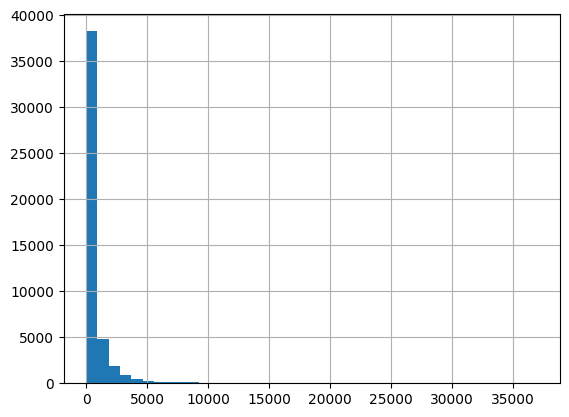

In [15]:
# Plot a graph to see the siz of text in combined_text
df["combined_text"].str.len().hist(bins = 40)

In [16]:
# Since roberta has a context window of 512 tokens (approx 2048 chars), drop rows with text > 2048 chars
df = df[df["combined_text"].str.len() < 2048]

In [20]:
# Calculate the sentiment of the combined text
kwargs = {'padding':True,'truncation':True,'max_length':512}
results = sentiment_pipeline(df["combined_text"].tolist(), **kwargs) 
df["label_1"] = [res["label"] for res in results]
df["score_1"] = [res["score"] for res in results]

KeyboardInterrupt: 

In [ ]:
# Save the dataframe to a csv file
df.to_csv(r"../Data/labelled_data_1.csv", index=False)